<a href="https://colab.research.google.com/github/Pager07/TensorflowSpecialization/blob/master/C3W2_WordEmbeddingAndVis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Dowloading and loading Dataset

In [1]:
import tensorflow as tf
print(tf.__version__)

2.2.0


In [2]:
import tensorflow_datasets as tfds
imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete63Y1GZ/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete63Y1GZ/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete63Y1GZ/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [3]:
import numpy as np

train_data, test_data = imdb['train'],imdb['test']

In [6]:
training_sentences =[]
training_labels = []

testing_sentences = []
testing_labels = []

for sentence,label in train_data:
  #sentence(byte) inside tensor -> get the sentence out of tensor -> change it to utf-8
  training_sentences.append((sentence.numpy()).decode('utf8'))
  training_labels.append(label.numpy())

for s,l in test_data:
  testing_sentences.append((s.numpy()).decode('utf8'))
  testing_labels.append(l.numpy())

training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

#Tokenizing

In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#Tokeninzing 
vocab_size , oov_token = 10000, '<OOV>'
tokenizer = Tokenizer(num_words = vocab_size, oov_token= oov_token)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

#Forming Sequences 
max_length = 120
trunc_type ='post'
sequences= tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length)


#Visualizing the data

In [8]:
#trick: dict() takes a tuple list eg.[(key,value)] and intelligentlt converts into a dict
reverse_word_index = dict([(value,key) for (key,value) in word_index.items()])

In [9]:
def decode_review(text):
  return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_review(padded[3]))
print(training_sentences[3])

? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? this is the kind of film for a snowy sunday afternoon when the rest of the world can go ahead with its own business as you <OOV> into a big arm chair and <OOV> for a couple of hours wonderful performances from cher and nicolas cage as always gently row the plot along there are no <OOV> to cross no dangerous waters just a warm and witty <OOV> through new york life at its best a family film in every sense and one that deserves the praise it received
This is the kind of film for a snowy Sunday afternoon when the rest of the world can go ahead with its own business as you descend into a big arm-chair and mellow for a couple of hours. Wonderful performances from Cher and Nicolas Cage (as always) gently row the plot along. There are no rapids to cross, no dangerous waters, just a warm and witty paddle through New York life at its best. A family film in every sense and one that deserves the praise it received.


#Model

What is an embedding layer?
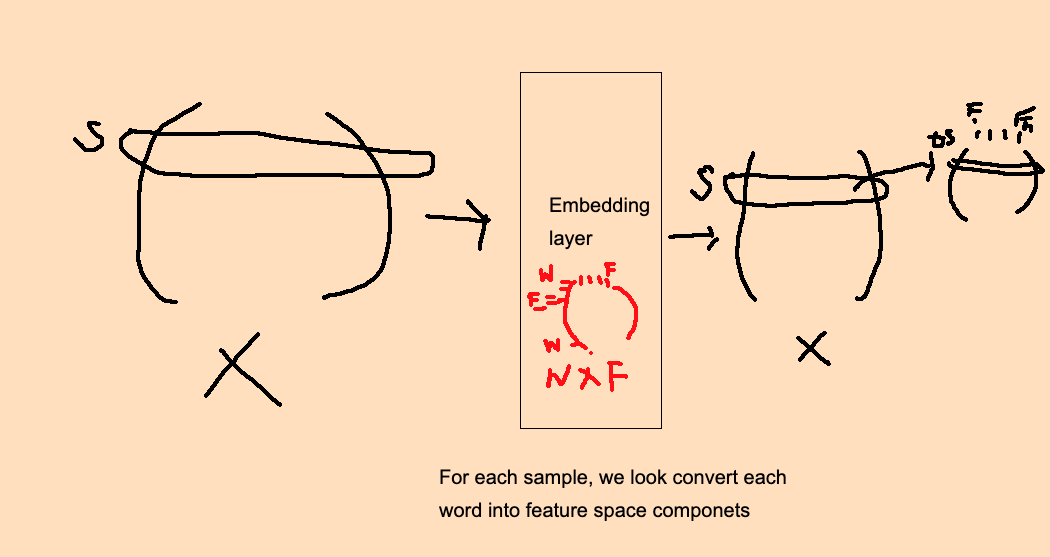

In [10]:
embedding_dim = 16
model = tf.keras.Sequential([
                             tf.keras.layers.Embedding(vocab_size,embedding_dim,input_length= max_length),
                             tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(6,activation='relu'),
                             tf.keras.layers.Dense(1,activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 16)           160000    
_________________________________________________________________
flatten (Flatten)            (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 6)                 11526     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 171,533
Trainable params: 171,533
Non-trainable params: 0
_________________________________________________________________


In [11]:
num_epochs = 10
model.fit(padded,training_labels_final,epochs=num_epochs,validation_data=(testing_padded,testing_labels_final))

Epoch 1/10
782/782 [==============================] - 8s 11ms/step - loss: 0.4888 - accuracy: 0.7446 - val_loss: 0.3440 - val_accuracy: 0.8472
Epoch 2/10
782/782 [==============================] - 7s 10ms/step - loss: 0.2429 - accuracy: 0.9060 - val_loss: 0.3723 - val_accuracy: 0.8385
Epoch 3/10
782/782 [==============================] - 7s 10ms/step - loss: 0.1004 - accuracy: 0.9726 - val_loss: 0.4447 - val_accuracy: 0.8324
Epoch 4/10
782/782 [==============================] - 7s 9ms/step - loss: 0.0255 - accuracy: 0.9965 - val_loss: 0.5291 - val_accuracy: 0.8276
Epoch 5/10
782/782 [==============================] - 7s 9ms/step - loss: 0.0060 - accuracy: 0.9995 - val_loss: 0.5925 - val_accuracy: 0.8277
Epoch 6/10
782/782 [==============================] - 8s 11ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.6525 - val_accuracy: 0.8266
Epoch 7/10
782/782 [==============================] - 8s 11ms/step - loss: 9.2147e-04 - accuracy: 1.0000 - val_loss: 0.6892 - val_accuracy: 0.82

In [ ]:
reverse_word_index

#Visualizing the embedding

https://projector.tensorflow.org/

In [17]:
e = model.layers[0] 
weights  = e.get_weights()[0] #returns list containg weight [w]
print(weights.shape)
#Recall: Embbeding matrix contains word to featuers (WxF)

(10000, 16)


In [23]:
import io 

#Sample Embedding

out_v = io.open('vecs.tsv','w',encoding='utf-8')
out_m = io.open('meta.tsv','w', encoding='utf-8')
for word_num in range(1,vocab_size):
  #get the word and the embedding from the matrix
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word+"\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [22]:
'\t'.join([str(x) for x in embeddings])

'-0.022748798\t-0.030574465\t0.009370636\t0.015312464\t0.02460502\t-0.02596873\t-0.06260167\t0.041383598\t-0.015380285\t0.027514363\t0.06019646\t-0.044853553\t0.013707537\t-0.015133285\t-0.039704688\t-0.03603636'

In [24]:
#Download the meta and vec files 
try:
  from google.colab import files 
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>